In [1]:
import os,cv2,keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from IPython import display

import config
from config import Config
import util

from keras.layers import Dense
from keras import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.utils import plot_model
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import LabelBinarizer
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

In [2]:
"""
Setting Custom Configuration
"""

class WiderFaceConfig(Config):
    """Configuration for training on WIDER face dataset.
    WiderFaceConfig classs derives from the base Config class and overrides configurations specific
    to the WIDER Face dataset.
    """
    NAME = "wider_face_experiment1"
    WEIGHTS = "imagenet"
    LEARNING_RATE = 0.0001
    ROTATION_RANGE_IMAGEGEN = 90
    DTYPE_IMAGEGEN = 'uint8'
    MONITOR = 'val_loss'
    SAVE_FREQ = 'epoch'
    STEPS_PER_EPOCH = 10
    TOTAL_EPOCHS = 1000
    VALIDATION_STEPS = 2
    NUM_CLASSES = 2

In [3]:
config = WiderFaceConfig()

In [4]:
#setting image and annotation paths
#image_path = "WIDER FACE/WIDER_train/images"
#annot_path = "WIDER FACE/wider_face_split"

image_path = "../WIDER FACE/wider_train_final/images"
annot_path = "../WIDER FACE/wider_train_final/annots"

0.jpg


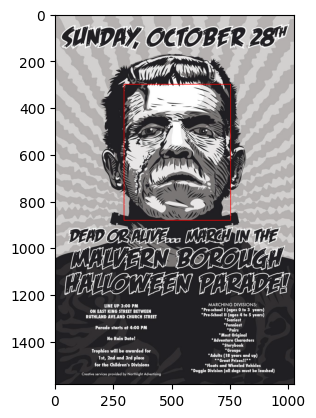

In [5]:
# draw rectangles on first image of the dataset using anotaions upto 9(<10)
for e,i in enumerate(os.listdir(annot_path)):
    if e < 21:
        filename = i.split(".")[0]+".jpg"
        print(filename)
        img = cv2.imread(os.path.join(image_path,filename), cv2.IMREAD_ANYCOLOR)
        df = pd.read_csv(os.path.join(annot_path,i), sep='\t', names=['temp'])
        #plt.imshow(img)
        for row in df.iterrows():
            x1 = int(row[1][0].split(" ")[0])
            y1 = int(row[1][0].split(" ")[1])
            x2 = int(row[1][0].split(" ")[2])
            y2 = int(row[1][0].split(" ")[3])
            cv2.rectangle(img,(x1,y1),(x2,y2),(255,0,0), 2)
        plt.figure()
        plt.imshow(img)
        break

In [6]:
#cv2.setUseOptimized(True);
#ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()


In [7]:
def selective_search(image_path, image_name):
    """
    perform Fast Selective Search for the passed image
    """
    
    cv2.setUseOptimized(True)

    img = cv2.imread(os.path.join(image_path, image_name))

    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(img)
    ss.switchToSelectiveSearchFast()
    ssresults = ss.process()
    
    return ssresults

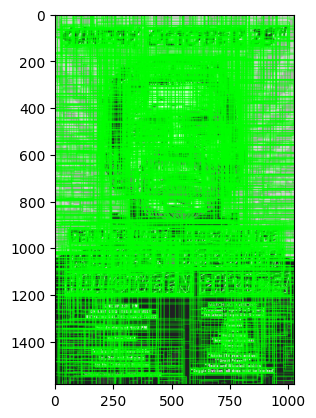

In [8]:
im = cv2.imread(os.path.join(image_path,"0.jpg"))
rects = selective_search(image_path,"0.jpg")
imOut = im.copy()
for i, rect in (enumerate(rects)):
    x, y, w, h = rect
#     print(x,y,w,h)
#     imOut = imOut[x:x+w,y:y+h]
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
# plt.figure()
plt.imshow(imOut)

# Image Preprocessing

In [9]:
train_images=[]
train_labels=[]

In [10]:
#cv2.setUseOptimized(True);
#ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [ ]:
for e,i in enumerate(os.listdir(annot_path)):
    try:
        #if i.startswith("airplane"):
            filename = i.split(".")[0]+".jpg"
            print(e,filename)
            image = cv2.imread(os.path.join(image_path,filename))
            df = pd.read_csv(os.path.join(annot_path,i), sep='\t', names=['temp'])
            gtvalues=[] 
            for row in df.iterrows():
                x1 = int(row[1][0].split(" ")[0])
                y1 = int(row[1][0].split(" ")[1])
                x2 = int(row[1][0].split(" ")[2])
                y2 = int(row[1][0].split(" ")[3])
                 # appending groundtruth values
                gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
            #ss.setBaseImage(image)
            #ss.switchToSelectiveSearchFast()
            #ssresults = ss.process()
            ssresults = selective_search(image_path, filename)
            imout = image.copy()
            counter = 0
            falsecounter = 0
            flag = 0
            fflag = 0
            bflag = 0
            for e,result in enumerate(ssresults):
                if e < config.MAX_REGIONS and flag == 0:
                    for gtval in gtvalues:
                        x,y,w,h = result
                        iou = util.calculate_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                        if counter < 30:
                            if iou > 0.70:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (config.IMAGE_MIN_DIM, config.IMAGE_MAX_DIM), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(1)
                                counter += 1
                        else :
                            fflag =1
                        if falsecounter <30:
                            if iou < 0.3:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (config.IMAGE_MIN_DIM,config.IMAGE_MAX_DIM), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(0)
                                falsecounter += 1
                        else :
                            bflag = 1
                    if fflag == 1 and bflag == 1:
                        print("inside")
                        flag = 1
    except Exception as e:
        print(e)
        print("error in "+filename)
        continue

0 0.jpg
1 1.jpg
2 10.jpg
3 100.jpg
4 101.jpg
5 102.jpg
6 103.jpg
7 104.jpg
8 105.jpg
9 106.jpg
10 107.jpg
11 108.jpg
12 109.jpg
13 11.jpg
14 110.jpg
15 111.jpg
16 112.jpg
17 113.jpg
18 114.jpg
19 115.jpg
20 116.jpg
21 117.jpg
22 118.jpg
23 119.jpg
24 12.jpg
25 120.jpg
26 121.jpg
27 122.jpg
28 123.jpg
29 124.jpg


In [ ]:
X_new = np.array(train_images)
y_new = np.array(train_labels)

In [ ]:
X_new.shape

# Model Formation and Training

In [ ]:
# transfer learning from VGG16 model with imagenet weights.
vggmodel = VGG16(weights=config.WEIGHTS , include_top=True)
vggmodel.summary()

In [ ]:
#freezing the first 15(index 0 to 14) layers in vggmodel
for layers in (vggmodel.layers)[:15]:
    print(layers)
    layers.trainable = False

In [ ]:
vggmodel.layers[-2]

In [ ]:
X = vggmodel.layers[-2].output

In [ ]:
predictions = Dense(2, activation="softmax")(X)

In [ ]:
model_final = Model(inputs = vggmodel.input, 
                    outputs = predictions)

In [ ]:
opt = Adam(learning_rate=config.LEARNING_RATE)

In [ ]:
model_final.compile(loss = keras.losses.categorical_crossentropy, 
                    optimizer = opt, 
                    metrics=["accuracy"])

In [ ]:
lenc = util.MyLabelBinarizer()
Y =  lenc.fit_transform(y_new)

In [ ]:
X_train, X_test , y_train, y_test = train_test_split(X_new,Y,test_size=0.10)

In [ ]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

In [ ]:
trdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=config.ROTATION_RANGE_IMAGEGEN, dtype=config.DTYPE_IMAGEGEN)
train_data = trdata.flow(x=X_train, y=y_train)
tsdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=config.ROTATION_RANGE_IMAGEGEN, dtype=config.DTYPE_IMAGEGEN)
test_data = tsdata.flow(x=X_test, y=y_test)

In [ ]:
checkpoint = ModelCheckpoint("exp1_rcnn_vgg16_1.h5", monitor=config.MONITOR, verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq=config.SAVE_FREQ)
early = EarlyStopping(monitor=config.MONITOR, min_delta=config.MIN_DELTA, patience=config.PATIENCE, verbose=1, mode='auto')

In [ ]:
hist = model_final.fit(x= train_data, steps_per_epoch= config.STEPS_PER_EPOCH, epochs= config.TOTAL_EPOCHS, validation_data= test_data, validation_steps=config.VALIDATION_STEPS, callbacks=[checkpoint,early])

# Visualization of Training Results

In [ ]:
# plt.plot(hist.history["acc"])
# plt.plot(hist.history['val_acc'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()
plt.savefig('chart loss.png')

# Prediction

In [ ]:
im = X_test[15]
plt.imshow(im)
img = np.expand_dims(im, axis=0)
out= model_final.predict(img)
if out[0][0] > out[0][1]:
    print("face")
else:
    print("not face")

In [ ]:
rects = []
filename = '137.jpg'
img = cv2.imread(os.path.join(image_path, filename))
ssresults = selective_search(image_path, filename)
imout = img.copy()
for e,result in enumerate(ssresults):
    if e < config.MAX_REGIONS:
        x,y,w,h = result
        timage = imout[y:y+h,x:x+w]
        resized = cv2.resize(timage, (config.IMAGE_MIN_DIM, config.IMAGE_MAX_DIM), interpolation = cv2.INTER_AREA)
        img = np.expand_dims(resized, axis=0)
        out= model_final.predict(img)
        if out[0][0] > 0.65:
            rects.append([x, y, x+w, y+h])
            cv2.rectangle(imout, (x, y), (x+w, y+h), (255, 0, 127), 2, cv2.LINE_AA)
plt.figure()
plt.imshow(cv2.cvtColor(imout, cv2.COLOR_BGR2RGB))

In [ ]:
filename = '137.jpg'
img = cv2.imread(os.path.join(image_path, filename))
imout2 = img.copy()

rects_ = np.array(rects)
pick = util.non_max_suppression_fast(rects_, overlapThresh=0.50) #original = 0.65

# draw the final bounding boxes
for (xA, yA, xB, yB) in pick:
    cv2.rectangle(imout2, (xA, yA), (xB, yB), (0, 255, 0), 2)
    
plt.figure()
plt.imshow(cv2.cvtColor(imout2, cv2.COLOR_BGR2RGB))